#CafChem tools for using a simple AI Agent to perform chemistry-related tasks using HuggingFace models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/ChemAgent_CafChem.ipynb)

## This notebook allows you to:
- Load a model from HuggingFace
- Create a simple Agent using Langchain.
- View intermediate results of the Agent.
- compare against using the unadorned model.

## Requirements:
- This notebook will install several langchain and langgraph libraries and rdkit.
- Runs well on an L4 GPU (using a 7.67 GB model). Will run on the v2-8 TPU runtime, with only slightly slower inference imes. Cannot run on CPU. (Colab runtimes)

## Set-up

### Install libraries

In [1]:
!pip install -U ddgs -q
!pip install --upgrade --quiet  langchain-huggingface
!pip install langchain_core --quiet
! pip -q install langchain_community
!pip install -q langgraph
!pip install duckduckgo-search
! pip install rdkit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3

### Import libraries and start the model

In [2]:
import torch
from typing import Annotated, TypedDict
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, trim_messages, AIMessage, HumanMessage, ToolCall

from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import chain
from uuid import uuid4
import re
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, QED
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit.Chem import rdMolAlign
import os
from rdkit import RDConfig
from rdkit.Chem.Features.ShowFeats import _featColors as featColors
from rdkit.Chem.FeatMaps import FeatMaps

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
hf = HuggingFacePipeline.from_model_id(
    model_id="microsoft/Phi-4-mini-instruct",
    task="text-generation",
    pipeline_kwargs = {"max_new_tokens": 500, "temperature": 0.4})

chat_model = ChatHuggingFace(llm=hf)

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cpu


## Define Functions

### Chemistry Functions

In [20]:
def substitution_tool(smiles: str) -> list:
  '''
    A simple substitution routine that looks for a substituent on a phenyl ring and
    substitutes different fragments in that location. Returns a list of novel molecules and their
    QED score (1 is most drug-like, 0 is least drug-like).

      Args:
        smiles: the input smiles string
      Returns:
        new_smiles_string: a string of novel molecules and their QED scores.
  '''
  new_fragments = ["c(Cl)c", "c(F)c", "c(O)c", "c(C)c", "c(OC)c", "c([NH3+])c",
                   "c(Br)c", "c(C(F)(F)(F))c"]

  new_smiles = []
  for fragment in new_fragments:
    m = re.findall(r"c(\D\D*)c", smiles)
    if len(m) != 0:
      for group in m:
        #print(group)
        if fragment not in group:
          new_smile = smiles.replace(group[1:], fragment)
          new_smiles.append(new_smile)

  qeds = []
  for new_smile in new_smiles:
    qeds.append(get_qed(new_smile))

  new_smiles_string = "Novel Molecules or Analogues and QED values: \n"
  for i in range(len(new_smiles)):
    new_smiles_string += f"SMILES: {new_smiles[i]}, QED: {qeds[i]:.3f}\n"

  return new_smiles_string

def get_qed(smiles):
  '''
    Helper function to compute QED for a given molecule.
      Args:
        smiles: the input smiles string
      Returns:
        qed: the QED score of the molecule.
  '''
  mol = Chem.MolFromSmiles(smiles)
  qed = Chem.QED.default(mol)

  return qed

def lipinski_tool(smiles):
  '''
    A tool to calculate QED and other lipinski properties of a molecule.
      Args:
        smiles: the input smiles string
      Returns:
        props_string: a string of the QED and other lipinski properties of the molecule,
                      including Molecular Weight, LogP, HBA, HBD, Polar Surface Area,
                      Rotatable Bonds, Aromatic Rings and Undesireable Moieties.
  '''
  mol = Chem.MolFromSmiles(smiles)
  qed = Chem.QED.default(mol)

  p = Chem.QED.properties(mol)
  mw = p[0]
  logP = p[1]
  hba = p[2]
  hbd = p[3]
  psa = p[4]
  rb = p[5]
  ar = p[6]
  um = p[7]

  props_string = f'''QED and other lipinski properties of the molecule:
    SMILES: {smiles},
    QED: {qed:.3f},
    Molecular Weight: {mw:.3f},
    LogP: {logP:.3f},
    Hydrogen bond acceptors: {hba},
    Hydrogen bond donors: {hbd},
    Polar Surface Area: {psa:.3f},
    Rotatable Bonds: {rb},
    Aromatic Rings: {ar},
    Undesireable moieties: {um}
  '''

  return props_string

def pharm_feature_tool(known_smiles, test_smiles):
  '''
    A tool to compare the pharmacophore features of a query molecule against
    a those of a reference molecule and report the pharmacophore features of both and the feature
    score of the query molecule.

      Args:
        known_smiles: the reference smiles string
        test_smiles: the query smiles string
      Returns:
        props_string: a string of the pharmacophore features of both molecules and the feature
                      score of the query molecule.
  '''
  smiles = [known_smiles, test_smiles]
  mols = [Chem.MolFromSmiles(x) for x in smiles]

  mols = [Chem.AddHs(m) for m in mols]
  ps = AllChem.ETKDGv3()

  for m in mols:
      AllChem.EmbedMolecule(m,ps)

  o3d = rdMolAlign.GetO3A(mols[1],mols[0])
  o3d.Align()

  keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder', 'Aromatic', 'LumpedHydrophobe')
  feat_hash = {'Donor': 'Hydrogen bond donors', 'Acceptor': 'Hydrogen bond acceptors',
               'NegIonizable': 'Negatively ionizable groups', 'PosIonizable': 'Positively ionizable groups',
               'ZnBinder': 'Zinc Binders', 'Aromatic': 'Aromatic rings', 'LumpedHydrophobe': 'Hydrophobic/non-polar groups' }

  feat_vectors = []
  for m in mols:
      rawFeats = fdef.GetFeaturesForMol(m)
      feat_vectors.append([f for f in rawFeats if f.GetFamily() in keep])

  feat_maps = [FeatMaps.FeatMap(feats = x,weights=[1]*len(x),params=fmParams) for x in feat_vectors]
  test_score = feat_maps[0].ScoreFeats(feat_maps[1].GetFeatures())/min(feat_maps[1].GetNumFeatures(),feat_maps[0].GetNumFeatures())

  feats_known = {}
  feats_test = {}
  for feat in feat_vectors[0]:
    if feat.GetFamily() not in feats_known.keys():
      feats_known[feat.GetFamily()]  = 1
    else:
      feats_known[feat.GetFamily()] += 1

  for feat in feat_vectors[1]:
    if feat.GetFamily() not in feats_test.keys():
      feats_test[feat.GetFamily()]  = 1
    else:
      feats_test[feat.GetFamily()] += 1

  props_string = f"The Pharmacophore Feature Overlap Score of the test molecule \
versus the reference molecule is {test_score:.3f}. \n\n"

  for feat in feats_known.keys():
    props_string += f"There are {feats_known[feat]} {feat_hash[feat]} in the reference molecule. \n"

  for feat in feats_test.keys():
    props_string += f"There are {feats_test[feat]} {feat_hash[feat]} in the test molecule. \n"

  return props_string

### Agent-related functions

In [12]:
class State(TypedDict):
  '''
    The state of the agent.
  '''
  messages: Annotated[list, add_messages]

def first_node(state: State) -> State:
  '''
    The first node of the agent. This node receives the input and asks the LLM
    to determine which is the best tool to use to answer the QUERY TASK.

      Input: the initial prompt from the user. should contain only one of more of the following:

             smiles: the smiles string, task: the query task, path: the path to the file,
             reference: the reference smiles

             the value should be separated from the name by a ':' and each field should
             be separated from the previous one by a ','.

      Output: the smiles string and the QUERY TASK.
  '''
  query_smiles = None
  query_task = None
  query_path = None
  query_reference = None

  raw_input = state["messages"][-1].content
  parts = raw_input.split(',')
  for part in parts:
    if 'smiles' in part:
      query_smiles = part.split(':')[1]
    if 'task' in part:
      query_task = part.split(':')[1]
    if 'path' in part:
      query_path = part.split(':')[1]
    if 'reference' in part:
      query_reference = part.split(':')[1]
  #print(query_smiles, query_task)

  prompt = f'For the QUERY_TASK given below, determine if one of the tools descibed below \
can complete the task. If so, reply with only the tool name followed by "#". \
If the tools cannot complete the task, reply with "None #".\n SMILES: {query_smiles}, \
QUERY_TASK: {query_task}.\n \
Tools: \n \
lipinski_tool: this tool can calculate the following properties: Quantitative \
Estimate of Drug-likeness (QED), Molecular weight, LogP (measures lipophilicity, higher is more lipophilic), \
HBA, HBD, Polar Surface Area, Rotatable Bonds, Aromatic Rings and Undesireable Moieties. \n \
substitution_tool: this tool can generate analogues of the molecule by substituting \
different chemical groups on the original molecule. Returns a list of novel molecules and their \
QED score (1 is most drug-like, 0 is least drug-like). \n \
pharm_feature_tool: this tool can compare the pharmacophore features of a query molecule against \
a those of a reference molecule and report the pharmacophore features of both and the feature \
score of the query molecule. This score tells how the common features score against each other, but \
does not inform about features unique to each molecule.'

  res = chat_model.invoke(prompt)
  #print(res)

  tool = str(res).split('<|assistant|>')[1].split('#')[0].strip()
  answer = f"{tool}"
  if query_smiles is not None:
    answer += f", query smiles: {query_smiles}"
  if query_path is not None:
    answer += f", query path: {query_path}"
  if query_reference is not None:
    answer += f", query reference: {query_reference}"

  return {"messages": answer}

def router_node(state: State) -> State:
  '''
    This is the second node of the agent. It takes the tool suggestion from the first
    node and sends the appropriate data there. After receiving the response string,
    it sends it back to the LLM in the next node.

      Input: the tool suggestion from the first node.
      Output: the response string from the selectd tool.
  '''
  raw_input = state["messages"][-1].content
  parts = raw_input.split(',')
  tool_choice = raw_input.split(',')[0]
  for part in parts[1:]:
    if 'smiles' in part:
      query_smiles = part.split(':')[1].strip()
    if 'path' in part:
      query_path = part.split(':')[1].strip()
    if 'reference' in part:
      query_reference = part.split(':')[1].strip()

  #print(tool_choice)

  if "lipinski_tool" in tool_choice:
    props = lipinski_tool(query_smiles)
  elif "substitution_tool" in tool_choice:
    props = substitution_tool(query_smiles)
  elif "pharm_feature_tool" in tool_choice:
    props = pharm_feature_tool(query_reference, query_smiles)
  else:
    props = "Nothing"

  return {"messages": props}

def parser_node(state: State) -> State:
  '''
    This is the third node in the agent. It receives the output from the tool,
    puts it into a prompt as CONTEXT, and asks the LLM to answer the original
    query.

      Input: the output from the tool.
      Output: the answer to the original query.
  '''
  props_string = state["messages"][-1].content

  raw_input = state["messages"][0].content
  parts = raw_input.split(',')
  for part in parts:
    if 'task' in part:
      query_task = part

  prompt = f'Using the CONTEXT below, answer the original query, which \
was to answer the QUERY_TASK. End your answer with a "#" \
QUERY_TASK: {query_task}.\n \
CONTEXT: {props_string}.\n '

  res = chat_model.invoke(prompt)
  return {"messages": res}

def reflect_node(state: State) -> State:
  '''
    This is the fourth node of the agent. It recieves the LLMs previous answer and
    tries to improve it.

      Input: the LLMs last answer.
      Output: the improved answer.
  '''
  previous_answer = state["messages"][-1].content

  prompt = f'Look at the PREVIOUS ANSWER below which you provided. \
Write an improved answer based on the PREVIOUS ANSWER by adding additional \
clarifying and enriching information. End your new answer with a "#" \
PREVIOUS ANSWER: {previous_answer}.\n '

  res = chat_model.invoke(prompt)
  return {"messages": res}

def pretty_print(answer):
  final = str(answer['messages'][-1]).split('<|assistant|>')[-1].split('#')[0].strip("n").strip('\\').strip('n').strip('\\')
  for i in range(0,len(final),100):
    print(final[i:i+100])

def print_short(answer):
  for i in range(0,len(answer),100):
    print(answer[i:i+100])

### Build and compile agent

In [13]:
builder = StateGraph(State)
builder.add_node("first_node", first_node)
builder.add_node("router_node", router_node)
builder.add_node("parser_node", parser_node)
builder.add_node("reflect_node", reflect_node)

builder.add_edge(START, "first_node")
builder.add_edge("first_node", "router_node")
builder.add_edge("router_node", "parser_node")
builder.add_edge("parser_node", "reflect_node")
builder.add_edge("reflect_node", END)

graph = builder.compile()

## Use Agent

- the input prompt should contain only one of more of the following:

    ```smiles: the smiles string, task: the query task, path: the path to the file, reference: the reference smiles```

- the value should be separated from the name by a ':' and each field should
  be separated from the previous one by a ','.

### View graph image

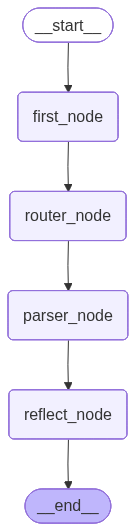

In [16]:
from PIL import Image
import io

img = graph.get_graph().draw_mermaid_png()
image = Image.open(io.BytesIO(img))
image

### Define prompt

In [10]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: pharmacophore evaluation, reference: O=C(O)[C@@](NN)(Cc1cc(O)c(O)cc1)C')
    ]
}

### Get intermediate output

In [14]:
cs = []
for c in graph.stream(input): #, stream_mode='updates'):
  m = re.findall(r'[a-z]+\_node', str(c))
  if len(m) != 0:
    reply = c[str(m[0])]['messages']
    if 'assistant' in str(reply):
      reply = str(reply).split("<|assistant|>")[-1].split('#')[0].strip()
  print_short(reply)
  cs.append(c)
  print('===================================================')

pharm_feature_tool, query smiles:  c1ccc(F)cc1, query reference:  O=C(O)[C@@](NN)(Cc1cc(O)c(O)cc1)C
The Pharmacophore Feature Overlap Score of the test molecule versus the reference molecule is 1.000.
 

There are 5 Hydrogen bond donors in the reference molecule. 
There are 4 Hydrogen bond acceptors 
in the reference molecule. 
There are 1 Negatively ionizable groups in the reference molecule. 
Ther
e are 1 Aromatic rings in the reference molecule. 
There are 1 Hydrophobic/non-polar groups in the r
eference molecule. 
There are 1 Hydrogen bond acceptors in the test molecule. 
There are 1 Aromatic 
rings in the test molecule. 
There are 1 Hydrophobic/non-polar groups in the test molecule. 

Given the provided context, the pharmacophore evaluation indicates that the test molecule has a perf
ect match with the reference molecule, as evidenced by the Pharmacophore Feature Overlap Score of 1.
000. This means that all the key features of the reference molecule are present in the test molecul

### Get only final answer

In [15]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: obeys lipinskis rules?')
    ]
}

In [16]:
answer = graph.invoke(input)

In [17]:
pretty_print(answer)

The molecule described by the SMILES c1ccc(F)cc1 has a QED (Quantitative Estimate of Drug-likeness) 
value of 0.462. Lipinski\'s Rule of Five states that, for a compound to have good oral bioavailabili
ty, it should have no more than 5 hydrogen bond donors, no more than 10 hydrogen bond acceptors, a m
olecular weight less than 500 g/mol, and a LogP (octanol-water partition coefficient) less than 5.\n
\nThe molecule in question has:\n- Molecular Weight: 96.10399999999998 (which is less than 500 g/mol
)\n- LogP: 1.826 (which is less than 5)\n- Hydrogen bond acceptors: 0\n- Hydrogen bond donors: 0\n\n
Based on these properties, the molecule obeys Lipinski\'s Rule of Five. Additionally, it has no pola
r surface area, which is often considered in drug-likeness evaluations, and it has no rotatable bond
s, which can impact the molecule\'s flexibility and, consequently, its ability to bind to biological
 targets. The presence of one aromatic ring can also be favorable for binding interactions 

In [18]:
input = {
    "messages": [
        HumanMessage('smiles: c1ccc(F)cc1, task: generate analogues')
    ]
}

In [19]:
answer = graph.invoke(input)
pretty_print(answer)

To generate analogues for the given SMILES and their corresponding QED values, we can consider subst
ituting different functional groups or atoms in the existing molecules while maintaining a similar s
tructural framework. Here are some analogues:\n\n1. SMILES: c1ccc(Cl)cc1, QED: 0.483\n   - Analogue:
 c1ccc(Br)cc1, QED: 0.542 (already provided, but can be considered an analogue due to similar haloge
n substitution)\n\n2. SMILES: c1ccc(O)cc1, QED: 0.515\n   - Analogue: c1ccc(OH)cc1, QED: 0.510 (hydr
oxyl group substitution)\n\n3. SMILES: c1ccc(C)cc1, QED: 0.459\n   - Analogue: c1ccc(CF3)cc1, QED: 0
.475 (trifluoromethyl group substitution)\n\n4. SMILES: c1ccc(OC)cc1, QED: 0.532\n   - Analogue: c1c
cc(OCH3)cc1, QED: 0.530 (methoxy group substitution)\n\n5. SMILES: c1ccc([NH3+])cc1, QED: 0.486\n   
- Analogue: c1ccc(NH2)cc1, QED: 0.490 (amino group substitution)\n\n6. SMILES: c1ccc(Br)cc1, QED: 0.
542\n   - Analogue: c1ccc(F)cc1, QED: 0.530 (fluorine substitution)\n\n7. SMILES: c1ccc(C(F

## Use the model alone without the agentic ability

In [ ]:
chat_model.invoke("does the molecule c1ccc(Br)cc1 obey Lipinski's rules??")

AIMessage(content='<|user|>What is the LogP of the molecule with the SMILES string c1ccc(O)cc1?<|end|><|assistant|>The LogP value of a molecule is a measure of its hydrophobicity, which is the tendency of a molecule to partition between a hydrophobic (nonpolar) phase and a hydrophobic phase. The SMILES string "c1ccc(O)cc1" represents 1,4-dimethylbenzene, also known as p-xylene.\n\nTo find the LogP value of 1,4-dimethylbenzene, we can use various chemical databases and software tools. According to the PubChem database, the LogP value of 1,4-dimethylbenzene is approximately 3.15.\n\nPlease note that the LogP value can vary slightly depending on the source and calculation method used.', additional_kwargs={}, response_metadata={}, id='run--d798b238-393f-4596-bd2d-b324328fd534-0')